# Logistic Regression

## Introduction

Logistic Regression is a statistical and machine learning technique used for binary classification. It predicts the probability that an observed input belongs to a default class, making it particularly useful for problems where the outcome is binary (e.g., yes/no, true/false, success/failure).

## Mathematical Model

At its core, logistic regression models the probability that an outcome belongs to a particular class. The logistic function, also called the sigmoid function, takes any real-valued number and maps it into a value between 0 and 1, but never exactly at those limits. Thus, it is especially suited for binary classification.

The logistic function is defined as:

\[ \sigma(t) = \frac{1}{1 + e^{-t}} \]

Where:
- \( \sigma(t) \) is the output of the logistic regression model,
- \( t \) is the linear combination of predictors, \( t = b_0 + b_1x_1 + b_2x_2 + \dots + b_nx_n \),
- \( b_0, b_1, ..., b_n \) are the coefficients, and
- \( x_1, x_2, ..., x_n \) are the feature values.

## Model Estimation

The parameters of logistic regression models are typically estimated using Maximum Likelihood Estimation (MLE). This method seeks to find the parameter values that maximize the likelihood of the observed sample.


# Logistic Regression Model for Predicting Customer Churn

This Jupyter Notebook demonstrates the application of a logistic regression model to predict customer churn in a telecommunications dataset. We will explore the dataset, perform necessary data preprocessing, train a logistic regression model, and evaluate its performance to predict whether a customer will churn.


In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


## Load and Explore the Dataset

We begin by loading the dataset and taking a preliminary look at its structure and contents. This will help us understand the features available and the preprocessing steps we might need to undertake.

In [2]:
# Load the dataset
data = pd.read_csv('C:/Users/78641/Downloads/Telco Customer Churn.csv')

# Display the first few rows of the dataframe
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [3]:
# Display general information about the dataframe
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
# Statistical summary of the dataframe
print(data.describe())

       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [5]:
# Check for missing values
print(data.isnull().sum())


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## Data Preprocessing

To prepare our dataset for modeling, we need to handle missing values, encode categorical variables, and scale numerical features. We also need to split our data into training and test sets.


In [6]:
# Print unique values in 'Churn' before mapping to see what might be missed
print("Unique values before mapping:", data['Churn'].unique())

# Apply the mapping
mapped_churn = data['Churn'].map({'Yes': 1, 'No': 0})

# Check for NaN values and unique values after mapping
print("Unique values after mapping:", mapped_churn.unique())
print("NaN counts after mapping:", mapped_churn.isna().sum())

Unique values before mapping: ['No' 'Yes']
Unique values after mapping: [0 1]
NaN counts after mapping: 0


In [7]:
# Since the mapping already results in integer values, directly use the mapped data
data['Churn'] = mapped_churn

# Confirm data type conversion
print("Data type of 'Churn' after conversion:", data['Churn'].dtype)

Data type of 'Churn' after conversion: int64


In [8]:
# Identifying categorical and numerical columns
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Removing target variable from numerical columns if it's there
numerical_cols.remove('Churn')

# Creating a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Split the dataset
X = data.drop('Churn', axis=1)
y = data['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Model Training

With our data prepared, we can now train a logistic regression model to predict customer churn.


In [9]:
# Create a pipeline that includes preprocessing and modeling
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Training the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['customerID', 'gender',
                                                   'Partner', 'Dependents',
                                                   'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'TotalCharges'])])),
                ('classifier', LogisticRegression(max_iter=1000))])

## Model Evaluation

Let's evaluate the model using the test set and review several key metrics to understand its performance.


Accuracy: 0.8254080908445706
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      1036
           1       0.70      0.59      0.64       373

    accuracy                           0.83      1409
   macro avg       0.78      0.75      0.76      1409
weighted avg       0.82      0.83      0.82      1409



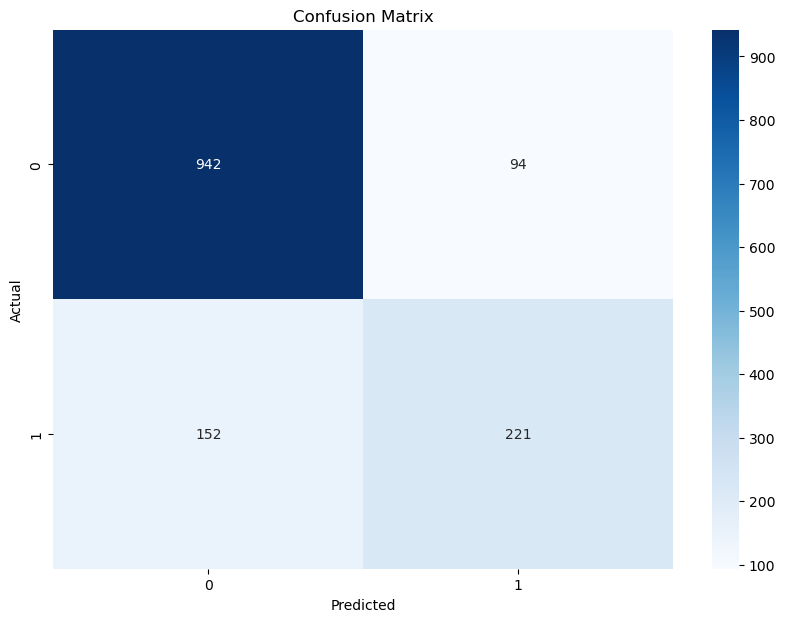

In [13]:
# Predicting the test set results
y_pred = model.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Plotting using seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Model Evaluation Summary

## Overview
The logistic regression model was applied to predict customer churn with an overall accuracy of 82.54%. The performance metrics detailed below provide insight into the model's strengths and limitations.

## Performance Metrics
- **Accuracy**: 82.54%
  - The model correctly predicted customer churn for 82.54% of the dataset. This indicates a strong general performance.

- **Precision**:
  - **Class 0 (Non-Churn)**: 86%
    - The model was highly precise in predicting non-churning customers.
  - **Class 1 (Churn)**: 70%
    - Precision for churning customers was lower, suggesting some non-churning customers were incorrectly labeled as churning.

- **Recall**:
  - **Class 0 (Non-Churn)**: 91%
    - The model successfully identified 91% of all actual non-churning cases.
  - **Class 1 (Churn)**: 59%
    - The recall for churning customers was lower, indicating that a significant number of churning customers were missed.

- **F1-Score**:
  - **Class 0 (Non-Churn)**: 88%
  - **Class 1 (Churn)**: 64%
    - F1-scores suggest that the model is more reliable in predicting non-churn than churn cases.

## Confusion Matrix Analysis
- **True Positives (TP) for Churn**: 221
- **True Negatives (TN) for Non-Churn**: 942
- **False Positives (FP)**: 94
  - These are cases where non-churning customers were incorrectly predicted as churning.
- **False Negatives (FN)**: 152
  - These are churning customers that the model failed to identify.

## Conclusion
The model performs well in identifying non-churning customers but struggles with accurately identifying all churning customers. The recall and precision for churn predictions suggest potential areas for improvement, possibly by tuning the model or employing more sophisticated algorithms. Further analysis and model tuning might focus on improving recall for churn without sacrificing precision.